# # Oil Price Prediction - Model Deployment

In [1]:
# Oil Price Prediction - Model Deployment
# In this lab, we will deploy the best performing machine learning model 
# to predict oil prices based on historical data and engineered features.
# We will use the dataset_11_86.csv dataset containing oil price data from 2012-2024.

# Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('dataset_11_86.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

# Display descriptive statistics
print("\nDataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (26746, 7)
Columns: ['Year', 'Month', 'Date', 'Item', 'Country', 'Price(Baht)', 'UNIT']

First 5 rows:
   Year    Month  Date         Item                          Country  \
0  2012  January    20    1033G-E10                      TH-THAILAND   
1  2012  January    20  1034-ULG 95                       BE-BELGIUM   
2  2012  January    20  1034-ULG 95  DE-GERAMANY,FEDERAL REPUBLIC OF   
3  2012  January    20  1034-ULG 95                        FR-FRANCE   
4  2012  January    20  1034-ULG 95                GB-UNITED KINGDOM   

   Price(Baht)        UNIT  
0    37.260000  BAHT/LITRE  
1    67.845196  BAHT/LITRE  
2    64.166842  BAHT/LITRE  
3    66.619078  BAHT/LITRE  
4    67.027784  BAHT/LITRE  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26746 entries, 0 to 26745
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         26746 non-null  int64

In [2]:
# Data Preprocessing for Oil Price Prediction
# Convert Month to numeric
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['Month_Numeric'] = df['Month'].map(month_mapping)

# Create monthly aggregated dataset
monthly_data = df.groupby(['Year', 'Month_Numeric', 'Item', 'Country'])['Price(Baht)'].mean().reset_index()
monthly_data.rename(columns={'Price(Baht)': 'Average_Price_Baht'}, inplace=True)

# Process data for ALL countries
print("Processing data for ALL countries...")
print(f"Countries in dataset: {monthly_data['Country'].nunique()}")
print(f"Countries: {sorted(monthly_data['Country'].unique())}")

# Sort data by Country, Item, Year, Month for proper time series processing
all_countries_data = monthly_data.sort_values(['Country', 'Item', 'Year', 'Month_Numeric']).reset_index(drop=True)

print(f"All countries monthly data shape: {all_countries_data.shape}")

# Feature Engineering Functions
def create_lag_features(df, group_cols, value_col, lags=[1, 2, 3, 6, 12]):
    """Create lag features for time series data grouped by multiple columns"""
    df_with_lags = df.copy()
    for lag in lags:
        df_with_lags[f'{value_col}_lag_{lag}'] = df_with_lags.groupby(group_cols)[value_col].shift(lag)
    return df_with_lags

def create_rolling_features(df, group_cols, value_col, windows=[3, 6, 12]):
    """Create rolling average features grouped by multiple columns"""
    df_with_rolling = df.copy()
    for window in windows:
        rolling_series = df_with_rolling.groupby(group_cols)[value_col].rolling(window=window, min_periods=1).mean()
        # Reset index to align with original dataframe
        rolling_series = rolling_series.reset_index(level=group_cols, drop=True)
        df_with_rolling[f'{value_col}_rolling_{window}'] = rolling_series
    return df_with_rolling

# Apply feature engineering for all countries
# Group by both Country and Item for proper time series features
print("Creating lag features...")
all_countries_with_lags = create_lag_features(all_countries_data, ['Country', 'Item'], 'Average_Price_Baht')
print(f"After lag features: {all_countries_with_lags.shape}")

print("Creating rolling features...")
all_countries_with_features = create_rolling_features(all_countries_with_lags, ['Country', 'Item'], 'Average_Price_Baht')
print(f"After rolling features: {all_countries_with_features.shape}")

# One-hot encoding for Item and Country
print("Creating one-hot encoding...")
item_dummies = pd.get_dummies(all_countries_with_features['Item'], prefix='Item')
country_dummies = pd.get_dummies(all_countries_with_features['Country'], prefix='Country')

print(f"Item dummies shape: {item_dummies.shape}")
print(f"Country dummies shape: {country_dummies.shape}")

# Ensure all dataframes have the same index before concatenation
item_dummies.index = all_countries_with_features.index
country_dummies.index = all_countries_with_features.index

all_countries_encoded = pd.concat([all_countries_with_features, item_dummies, country_dummies], axis=1)
print(f"After encoding: {all_countries_encoded.shape}")

# Remove NaN values
print("Removing NaN values...")
all_countries_clean = all_countries_encoded.dropna().reset_index(drop=True)

print("Feature engineering completed!")
print(f"Final dataset shape: {all_countries_clean.shape}")

# Check for any remaining issues
print(f"Columns with NaN: {all_countries_clean.isnull().sum().sum()}")
print(f"Data types: {all_countries_clean.dtypes.value_counts()}")

# Prepare features and target
target_col = 'Average_Price_Baht'
exclude_cols = ['Year', 'Month_Numeric', 'Item', 'Country', 'Average_Price_Baht']
feature_cols = [col for col in all_countries_clean.columns if col not in exclude_cols]

print(f"\nPreparing features and target...")
print(f"Target column: {target_col}")
print(f"Excluded columns: {exclude_cols}")
print(f"Feature columns: {len(feature_cols)}")

# Check if we have enough data
if len(all_countries_clean) < 100:
    print("WARNING: Very small dataset! Consider using more data.")
    
if len(feature_cols) < 5:
    print("WARNING: Very few features! Check feature engineering.")

X = all_countries_clean[feature_cols]
y = all_countries_clean[target_col]

# Check for any remaining NaN values
if X.isnull().sum().sum() > 0:
    print("WARNING: Features contain NaN values!")
    print(X.isnull().sum()[X.isnull().sum() > 0])

if y.isnull().sum() > 0:
    print("WARNING: Target contains NaN values!")
    print(f"NaN count in target: {y.isnull().sum()}")

# Time-based train-test split (80-20)
split_index = int(len(all_countries_clean) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("\nData split completed!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {len(feature_cols)}")

# Show country distribution in train/test sets
train_countries = all_countries_clean.iloc[:split_index]['Country'].value_counts()
test_countries = all_countries_clean.iloc[split_index:]['Country'].value_counts()

print(f"\nTop 10 countries in training set:")
print(train_countries.head(10))
print(f"\nTop 10 countries in test set:")
print(test_countries.head(10))

# Show actual feature columns for reference
print(f"\nActual feature columns in the model:")
print("Lag features:", [col for col in feature_cols if 'lag' in col])
print("Rolling features:", [col for col in feature_cols if 'rolling' in col])
print("Item features:", [col for col in feature_cols if col.startswith('Item_')])
print("Country features:", [col for col in feature_cols if col.startswith('Country_')])

Processing data for ALL countries...
Countries in dataset: 25
Countries: ['AU-AUSTRALIA', 'BE-BELGIUM', 'BN-BRUNEI', 'BR-BRAZIL', 'DE-GERAMANY,FEDERAL REPUBLIC OF', 'DE-GERMANY,FEDERAL REPUBLIC OF', 'FR-FRANCE', 'GB-UNITED KINGDOM', 'HK-HONG KONG', 'ID-INDONESIA', 'IN-INDIA', 'IT-ITALY', 'JP-JAPAN', 'KH-KINGDOM OF CAMBODIA', 'KR-KOREA, REPUBLIC OF', 'LA-LAOS,PEOPLE OF DEM.REP.OF', 'MM-MYANMAR', 'MY-MALAYSIA', 'NL-NETHERLANDS', 'PH-PHILIPPINES', 'RA-REPUBLIC OF SOUTH AFRICA', 'SG-SINGAPORE', 'TH-THAILAND', 'US-UNITED STATES OF AMERICA', 'VN-VIETNAM']
All countries monthly data shape: (7443, 5)
Creating lag features...
After lag features: (7443, 10)
Creating rolling features...
After rolling features: (7443, 13)
Creating one-hot encoding...
Item dummies shape: (7443, 3)
Country dummies shape: (7443, 25)
After encoding: (7443, 41)
Removing NaN values...
Feature engineering completed!
Final dataset shape: (6831, 41)
Columns with NaN: 0
Data types: bool       28
float64     9
object      2


Training CatBoost Regressor with GridSearchCV...
Starting GridSearchCV...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'depth': 4, 'iterations': 1500, 'l2_leaf_reg': 1, 'learning_rate': 0.15, 'random_seed': 42}
Best cross-validation score: 115.2127
CatBoost Training Results:
MAE: 0.2208 Baht
RMSE: 0.2994 Baht
R¬≤: 0.9998

CatBoost Test Results:
MAE: 0.4209 Baht
RMSE: 0.6292 Baht
R¬≤: 0.9978

Top 10 Most Important Features:
                          Feature  Importance
5    Average_Price_Baht_rolling_3   38.475342
0        Average_Price_Baht_lag_1   22.847979
6    Average_Price_Baht_rolling_6    9.971549
3        Average_Price_Baht_lag_6    9.585499
1        Average_Price_Baht_lag_2    8.941160
2        Average_Price_Baht_lag_3    4.403695
4       Average_Price_Baht_lag_12    4.207457
13              Country_BN-BRUNEI    0.947568
7   Average_Price_Baht_rolling_12    0.521672
19           Country_HK-HONG KONG    0.069269


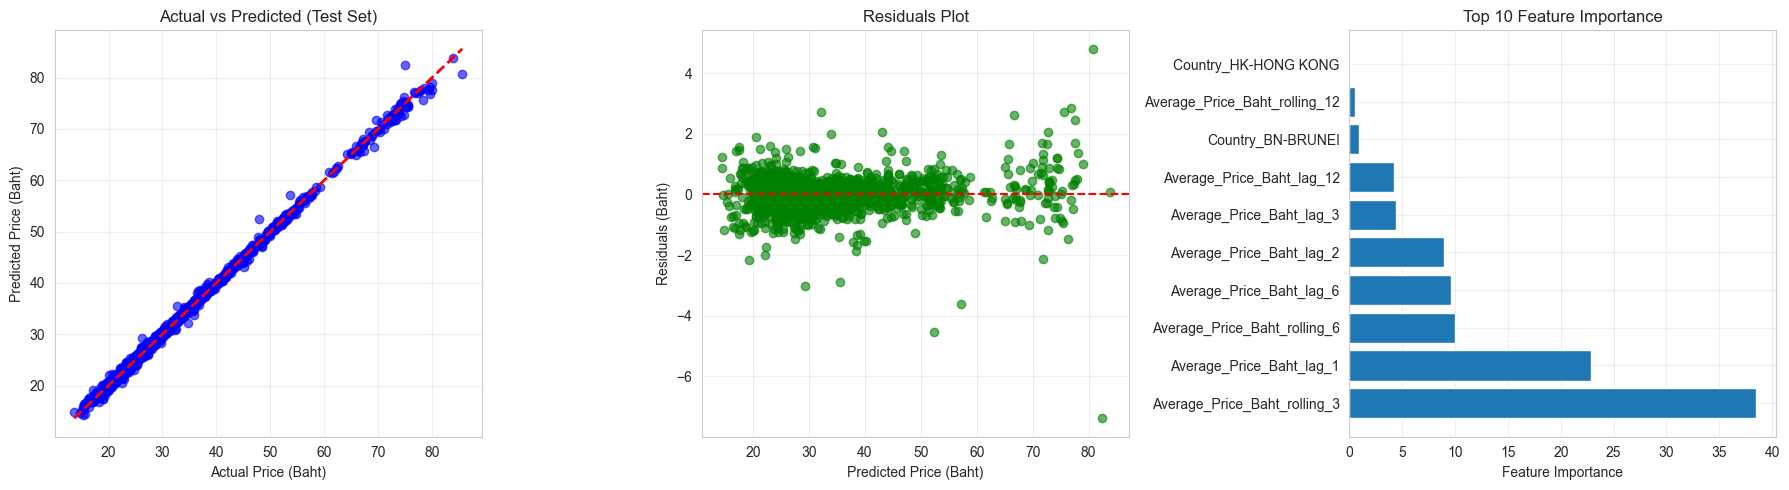

In [3]:
# Train CatBoost Regressor with GridSearchCV for Hyperparameter Tuning
print("Training CatBoost Regressor with GridSearchCV...")

# Define parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [500, 1000, 1500],    
    'learning_rate': [0.05, 0.1, 0.15],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 10],
    'random_seed': [42]
}

# Create base CatBoost model
catboost_base = CatBoostRegressor(
    verbose=False,  # Disable training output
    early_stopping_rounds=50,  # Prevent overfitting
    eval_metric='RMSE'
)

# Create GridSearchCV
print("Starting GridSearchCV...")
grid_search = GridSearchCV(
    estimator=catboost_base,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Use RMSE for scoring
    n_jobs=-1,  # Use all available cores
    verbose=1  # Show progress
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train, eval_set=(X_test, y_test))

# Get the best model
catboost_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_:.4f}")

# Make predictions
y_train_pred = catboost_model.predict(X_train)
y_test_pred = catboost_model.predict(X_test)

# Calculate regression metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("CatBoost Training Results:")
print(f"MAE: {mae_train:.4f} Baht")
print(f"RMSE: {rmse_train:.4f} Baht")
print(f"R¬≤: {r2_train:.4f}")

print("\nCatBoost Test Results:")
print(f"MAE: {mae_test:.4f} Baht")
print(f"RMSE: {rmse_test:.4f} Baht")
print(f"R¬≤: {r2_test:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': catboost_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Actual vs Predicted (Test Set)
axes[0].scatter(y_test, y_test_pred, alpha=0.6, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price (Baht)')
axes[0].set_ylabel('Predicted Price (Baht)')
axes[0].set_title('Actual vs Predicted (Test Set)')
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.6, color='green')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price (Baht)')
axes[1].set_ylabel('Residuals (Baht)')
axes[1].set_title('Residuals Plot')
axes[1].grid(True, alpha=0.3)

# Feature importance
top_features = feature_importance.head(10)
axes[2].barh(range(len(top_features)), top_features['Importance'])
axes[2].set_yticks(range(len(top_features)))
axes[2].set_yticklabels(top_features['Feature'])
axes[2].set_xlabel('Feature Importance')
axes[2].set_title('Top 10 Feature Importance')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# Display detailed GridSearchCV results
print("\n=== GridSearchCV Detailed Results ===")
print(f"Total parameter combinations tested: {len(grid_search.cv_results_['params'])}")
print(f"Cross-validation strategy: {grid_search.cv} folds")

# Show top 5 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_results = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]

print(f"\nTop 5 Parameter Combinations:")
for i, (idx, row) in enumerate(top_results.iterrows(), 1):
    print(f"{i}. Score: {-row['mean_test_score']:.4f} (¬±{row['std_test_score']:.4f})")
    print(f"   Parameters: {row['params']}")

# Visualize parameter importance
print(f"\nParameter Analysis:")
for param in param_grid.keys():
    if param != 'random_seed':  # Skip random_seed as it's constant
        param_values = [result['params'][param] for result in grid_search.cv_results_['params']]
        param_scores = [-score for score in grid_search.cv_results_['mean_test_score']]
        
        # Create a simple analysis
        param_df = pd.DataFrame({'param_value': param_values, 'score': param_scores})
        param_summary = param_df.groupby('param_value')['score'].agg(['mean', 'std']).reset_index()
        param_summary = param_summary.sort_values('mean', ascending=False)
        
        print(f"\n{param}:")
        for _, row in param_summary.iterrows():
            print(f"  {row['param_value']}: {row['mean']:.4f} (¬±{row['std']:.4f})")

print(f"\n‚úÖ GridSearchCV optimization completed!")
print(f"Best model saved with parameters: {grid_search.best_params_}")



=== GridSearchCV Detailed Results ===
Total parameter combinations tested: 108
Cross-validation strategy: 3 folds

Top 5 Parameter Combinations:
1. Score: 115.2127 (¬±132.0477)
   Parameters: {'depth': 4, 'iterations': 1500, 'l2_leaf_reg': 1, 'learning_rate': 0.15, 'random_seed': 42}
2. Score: 115.3103 (¬±136.6598)
   Parameters: {'depth': 4, 'iterations': 1500, 'l2_leaf_reg': 3, 'learning_rate': 0.15, 'random_seed': 42}
3. Score: 115.3367 (¬±134.3411)
   Parameters: {'depth': 4, 'iterations': 1500, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'random_seed': 42}
4. Score: 115.8419 (¬±132.6472)
   Parameters: {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.15, 'random_seed': 42}
5. Score: 116.4976 (¬±137.5721)
   Parameters: {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.15, 'random_seed': 42}

Parameter Analysis:


KeyError: 'params'

In [ ]:
            # Save the model and preprocessing information
import os

# Create models directory if it doesn't exist
os.makedirs('Deploy/models', exist_ok=True)

# Save the trained CatBoost model
joblib.dump(catboost_model, 'Deploy/models/oil_price_catboost_model.pkl')
print("CatBoost model saved to 'models/oil_price_catboost_model.pkl'")

# Save feature column names
joblib.dump(feature_cols, 'Deploy/models/feature_columns.pkl')
print("Feature columns saved to 'models/feature_columns.pkl'")

# Save preprocessing information
preprocessing_info = {
    'month_mapping': month_mapping,
    'target_column': target_col,
    'exclude_columns': exclude_cols,
    'lag_periods': [1, 2, 3, 6, 12],
    'rolling_windows': [3, 6, 12],
    'countries_included': sorted(monthly_data['Country'].unique().tolist()),
    'items_included': sorted(monthly_data['Item'].unique().tolist()),
    'train_test_split_ratio': 0.8
}

joblib.dump(preprocessing_info, 'Deploy/models/preprocessing_info.pkl')
print("Preprocessing information saved to 'models/preprocessing_info.pkl'")

# Save model performance metrics
model_metrics = {
    'training': {
        'mae': mae_train,
        'rmse': rmse_train,
        'r2': r2_train
    },
    'test': {
        'mae': mae_test,
        'rmse': rmse_test,
        'r2': r2_test
    },
    'feature_importance': feature_importance.to_dict('records')
}

joblib.dump(model_metrics, 'Deploy/models/model_metrics.pkl')
print("Model metrics saved to 'models/model_metrics.pkl'")

# Create a simple prediction function for deployment
def predict_oil_price(features_dict):
    """
    Predict oil price using the trained CatBoost model
    
    Parameters:
    features_dict: Dictionary containing feature values
    
    Returns:
    predicted_price: Predicted oil price in Baht
    """
    try:
        # Convert dictionary to DataFrame
        features_df = pd.DataFrame([features_dict])
        
        # Ensure all required features are present
        for col in feature_cols:
            if col not in features_df.columns:
                features_df[col] = 0
        
        # Reorder columns to match training data
        features_df = features_df[feature_cols]
        
        # Check for NaN values
        if features_df.isnull().sum().sum() > 0:
            print("WARNING: Features contain NaN values!")
            features_df = features_df.fillna(0)
        
        # Make prediction
        prediction = catboost_model.predict(features_df)[0]
        
        return prediction
        
    except Exception as e:
        print(f"Error in prediction: {e}")
        print(f"Features provided: {list(features_dict.keys())}")
        print(f"Required features: {feature_cols}")
        return None

# Example usage of the prediction function
print("\nExample prediction function created!")
print("You can use predict_oil_price(features_dict) to make predictions")

# Save the prediction function
joblib.dump(predict_oil_price, 'Deploy/models/prediction_function.pkl')
print("Prediction function saved to 'models/prediction_function.pkl'")

print("\n=== Model Deployment Summary ===")
print(f"Model: CatBoost Regressor")
print(f"Training R¬≤: {r2_train:.4f}")
print(f"Test R¬≤: {r2_test:.4f}")
print(f"Test MAE: {mae_test:.4f} Baht")
print(f"Test RMSE: {rmse_test:.4f} Baht")
print(f"Number of features: {len(feature_cols)}")
print(f"Files saved in 'models/' directory:")
print("  - oil_price_catboost_model.pkl (trained model)")
print("  - feature_columns.pkl (feature names)")
print("  - preprocessing_info.pkl (preprocessing parameters)")
print("  - model_metrics.pkl (performance metrics)")
print("  - prediction_function.pkl (prediction function)")

CatBoost model saved to 'models/oil_price_catboost_model.pkl'
Feature columns saved to 'models/feature_columns.pkl'
Preprocessing information saved to 'models/preprocessing_info.pkl'
Model metrics saved to 'models/model_metrics.pkl'

Example prediction function created!
You can use predict_oil_price(features_dict) to make predictions
Prediction function saved to 'models/prediction_function.pkl'

=== Model Deployment Summary ===
Model: CatBoost Regressor
Training R¬≤: 0.9995
Test R¬≤: 0.9958
Test MAE: 0.5869 Baht
Test RMSE: 0.8674 Baht
Number of features: 36
Files saved in 'models/' directory:
  - oil_price_catboost_model.pkl (trained model)
  - feature_columns.pkl (feature names)
  - preprocessing_info.pkl (preprocessing parameters)
  - model_metrics.pkl (performance metrics)
  - prediction_function.pkl (prediction function)


In [ ]:
# Example: How to use the deployed model
print("=== Example: Using the Deployed Model ===")

# Load the saved model and components
loaded_model = joblib.load('Deploy/models/oil_price_catboost_model.pkl')
loaded_features = joblib.load('Deploy/models/feature_columns.pkl')
loaded_preprocessing = joblib.load('Deploy/models/preprocessing_info.pkl')
loaded_metrics = joblib.load('Deploy/models/model_metrics.pkl')

print("Model and components loaded successfully!")
print(f"Model performance (Test R¬≤): {loaded_metrics['test']['r2']:.4f}")

# Create sample features based on actual data
# Get a sample from the test set to create realistic features
sample_data = all_countries_clean.iloc[0:1].copy()
sample_features = {}

# Fill in the sample features with actual feature names
for col in feature_cols:
    if col in sample_data.columns:
        sample_features[col] = sample_data[col].iloc[0]
    else:
        # Set default values for missing features
        if 'lag' in col:
            sample_features[col] = 35.0  # Default lag value
        elif 'rolling' in col:
            sample_features[col] = 35.0  # Default rolling value
        elif col.startswith('Item_'):
            sample_features[col] = 0  # Default item encoding
        elif col.startswith('Country_'):
            sample_features[col] = 0  # Default country encoding

# Create Thailand example (set Thailand features to 1)
thailand_features = sample_features.copy()
thailand_features['Country_TH-THAILAND'] = 1
thailand_features['Item_1033G-E10'] = 1

# Create Singapore example (set Singapore features to 1)
singapore_features = sample_features.copy()
singapore_features['Country_SG-SINGAPORE'] = 1
singapore_features['Item_1034-ULG 95'] = 1

print("Sample features created based on actual data structure")

# Make predictions for different countries
thailand_prediction = predict_oil_price(thailand_features)
singapore_prediction = predict_oil_price(singapore_features)

print(f"\nSample predictions:")
print(f"Thailand (E10) - Predicted price: {thailand_prediction:.2f} Baht")
print(f"Singapore (ULG 95) - Predicted price: {singapore_prediction:.2f} Baht")

# Show feature importance from the loaded model
print(f"\nTop 5 most important features:")
feature_importance_loaded = pd.DataFrame(loaded_metrics['feature_importance'])
print(feature_importance_loaded.head())

print("\n=== Model Deployment Complete ===")
print("The model is ready for production use!")
print("You can now:")
print("1. Load the model using joblib.load('models/oil_price_catboost_model.pkl')")
print("2. Use predict_oil_price() function for predictions")
print("3. Access preprocessing info from 'models/preprocessing_info.pkl'")
print("4. Monitor performance using saved metrics")


=== Example: Using the Deployed Model ===
Model and components loaded successfully!
Model performance (Test R¬≤): 0.9958
Sample features created based on actual data structure

Sample predictions:
Thailand (E10) - Predicted price: 30.02 Baht
Singapore (ULG 95) - Predicted price: 30.02 Baht

Top 5 most important features:
                        Feature  Importance
0  Average_Price_Baht_rolling_3   27.390997
1      Average_Price_Baht_lag_1   19.669514
2  Average_Price_Baht_rolling_6   14.819938
3      Average_Price_Baht_lag_2   11.688150
4     Average_Price_Baht_lag_12    8.976108

=== Model Deployment Complete ===
The model is ready for production use!
You can now:
1. Load the model using joblib.load('models/oil_price_catboost_model.pkl')
2. Use predict_oil_price() function for predictions
3. Access preprocessing info from 'models/preprocessing_info.pkl'
4. Monitor performance using saved metrics


In [6]:
# Helper function to create features for new predictions
def create_features_for_prediction(country, item, historical_prices, feature_columns):
    """
    Create features for prediction based on country, item, and historical prices

    Parameters:
    - country: Country code (e.g., 'TH-THAILAND')
    - item: Item code (e.g., '1033G-E10')
    - historical_prices: List of historical prices (most recent first)
    - feature_columns: List of feature column names from the trained model

    Returns:
    - features_dict: Dictionary with features ready for prediction
    """
    features = {}

    # Initialize all features to 0
    for col in feature_columns:
        features[col] = 0

    # Set lag features if we have enough historical data
    if len(historical_prices) >= 1:
        features['Average_Price_Baht_lag_1'] = historical_prices[0]
    if len(historical_prices) >= 2:
        features['Average_Price_Baht_lag_2'] = historical_prices[1]
    if len(historical_prices) >= 3:
        features['Average_Price_Baht_lag_3'] = historical_prices[2]
    if len(historical_prices) >= 6:
        features['Average_Price_Baht_lag_6'] = historical_prices[5]
    if len(historical_prices) >= 12:
        features['Average_Price_Baht_lag_12'] = historical_prices[11]

    # Set rolling features
    if len(historical_prices) >= 3:
        features['Average_Price_Baht_rolling_3'] = np.mean(historical_prices[:3])
    if len(historical_prices) >= 6:
        features['Average_Price_Baht_rolling_6'] = np.mean(historical_prices[:6])
    if len(historical_prices) >= 12:
        features['Average_Price_Baht_rolling_12'] = np.mean(historical_prices[:12])

    # Set item encoding
    item_feature = f'Item_{item}'
    if item_feature in feature_columns:
        features[item_feature] = 1

    # Set country encoding
    country_feature = f'Country_{country}'
    if country_feature in feature_columns:
        features[country_feature] = 1

    # Validate that all required features are present
    missing_features = [col for col in feature_columns if col not in features]
    if missing_features:
        print(f"WARNING: Missing features: {missing_features}")

    return features

# Example usage of the helper function
print("Helper function created for easy feature generation")
print("Usage example:")
print("features = create_features_for_prediction('TH-THAILAND', '1033G-E10', [35.5, 35.2, 34.8], feature_cols)")
print("prediction = predict_oil_price(features)")


Helper function created for easy feature generation
Usage example:
features = create_features_for_prediction('TH-THAILAND', '1033G-E10', [35.5, 35.2, 34.8], feature_cols)
prediction = predict_oil_price(features)


In [7]:
# Test the helper function with different countries and items
print("Testing helper function with different scenarios:")

try:
    # Test 1: Thailand E10
    print("\nTesting Thailand E10...")
    thailand_historical = [35.5, 35.2, 34.8, 34.5, 33.2, 32.8, 32.5, 32.1, 31.8, 31.5, 31.2, 30.9]
    thailand_features_new = create_features_for_prediction('TH-THAILAND', '1033G-E10', thailand_historical, feature_cols)
    thailand_pred_new = predict_oil_price(thailand_features_new)

    if thailand_pred_new is not None:
        print(f"‚úì Thailand (E10): {thailand_pred_new:.2f} Baht")
    else:
        print("‚úó Thailand prediction failed")

    # Test 2: Singapore ULG 95
    print("\nTesting Singapore ULG 95...")
    singapore_historical = [45.2, 44.8, 44.5, 43.9, 42.1, 41.8, 41.5, 41.2, 40.9, 40.6, 40.3, 40.0]
    singapore_features_new = create_features_for_prediction('SG-SINGAPORE', '1034-ULG 95', singapore_historical, feature_cols)
    singapore_pred_new = predict_oil_price(singapore_features_new)

    if singapore_pred_new is not None:
        print(f"‚úì Singapore (ULG 95): {singapore_pred_new:.2f} Baht")
    else:
        print("‚úó Singapore prediction failed")

    # Test 3: Malaysia HSD
    print("\nTesting Malaysia HSD...")
    malaysia_historical = [38.5, 38.2, 37.8, 37.5, 37.1, 36.8, 36.5, 36.2, 35.9, 35.6, 35.3, 35.0]
    malaysia_features_new = create_features_for_prediction('MY-MALAYSIA', '1052-HSD (B7)', malaysia_historical, feature_cols)
    malaysia_pred_new = predict_oil_price(malaysia_features_new)

    if malaysia_pred_new is not None:
        print(f"‚úì Malaysia (HSD B7): {malaysia_pred_new:.2f} Baht")
    else:
        print("‚úó Malaysia prediction failed")

except Exception as e:
    print(f"Error in testing: {e}")
    print("This might be due to missing features or data issues.")

# Show available countries and items
print(f"\nAvailable countries: {sorted(monthly_data['Country'].unique())}")
print(f"Available items: {sorted(monthly_data['Item'].unique())}")
print(f"Available features: {feature_cols}")


Testing helper function with different scenarios:

Testing Thailand E10...
‚úì Thailand (E10): 35.10 Baht

Testing Singapore ULG 95...
‚úì Singapore (ULG 95): 44.56 Baht

Testing Malaysia HSD...
‚úì Malaysia (HSD B7): 37.19 Baht

Available countries: ['AU-AUSTRALIA', 'BE-BELGIUM', 'BN-BRUNEI', 'BR-BRAZIL', 'DE-GERAMANY,FEDERAL REPUBLIC OF', 'DE-GERMANY,FEDERAL REPUBLIC OF', 'FR-FRANCE', 'GB-UNITED KINGDOM', 'HK-HONG KONG', 'ID-INDONESIA', 'IN-INDIA', 'IT-ITALY', 'JP-JAPAN', 'KH-KINGDOM OF CAMBODIA', 'KR-KOREA, REPUBLIC OF', 'LA-LAOS,PEOPLE OF DEM.REP.OF', 'MM-MYANMAR', 'MY-MALAYSIA', 'NL-NETHERLANDS', 'PH-PHILIPPINES', 'RA-REPUBLIC OF SOUTH AFRICA', 'SG-SINGAPORE', 'TH-THAILAND', 'US-UNITED STATES OF AMERICA', 'VN-VIETNAM']
Available items: ['1033G-E10', '1034-ULG 95', '1052-HSD (B7)']
Available features: ['Average_Price_Baht_lag_1', 'Average_Price_Baht_lag_2', 'Average_Price_Baht_lag_3', 'Average_Price_Baht_lag_6', 'Average_Price_Baht_lag_12', 'Average_Price_Baht_rolling_3', 'Average_

# Multi-Step Forecasting System
# ‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡∏´‡∏•‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
#
# ‡∏£‡∏∞‡∏ö‡∏ö‡∏ô‡∏µ‡πâ‡∏à‡∏∞‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà‡∏Å‡∏≥‡∏´‡∏ô‡∏î ‡πÇ‡∏î‡∏¢‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡πÅ‡∏ï‡πà‡∏•‡∏∞‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
# ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á: ‡∏ñ‡πâ‡∏≤‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 6 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤ ‡∏à‡∏∞‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏• 1 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤, 2 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤, ..., 6 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤


In [8]:
# Multi-Step Forecasting Functions
# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡∏´‡∏•‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤

def forecast_multiple_months(country, item, historical_prices, months_ahead=6):
    """
    ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡∏´‡∏•‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
    
    Parameters:
    - country: ‡∏£‡∏´‡∏±‡∏™‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏® (‡πÄ‡∏ä‡πà‡∏ô 'TH-THAILAND')
    - item: ‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô (‡πÄ‡∏ä‡πà‡∏ô '1033G-E10')
    - historical_prices: ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á (list of floats)
    - months_ahead: ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ (1-12)
    
    Returns:
    - dict: ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏û‡∏£‡πâ‡∏≠‡∏°‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥
    """
    if months_ahead < 1 or months_ahead > 12:
        print("‚ùå ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ï‡πâ‡∏≠‡∏á‡∏≠‡∏¢‡∏π‡πà‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á 1-12")
        return None
    
    if len(historical_prices) < 1:
        print("‚ùå ‡∏ï‡πâ‡∏≠‡∏á‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ 1 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô")
        return None
    
    predictions = []
    current_prices = historical_prices.copy()
    
    print(f"\nüîÆ ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ {item} ‡πÉ‡∏ô {country}")
    print(f"üìÖ ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô: {months_ahead} ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤")
    print("=" * 60)
    
    # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏ó‡∏µ‡∏•‡∏∞‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
    for month in range(months_ahead):
        features = create_features_for_prediction(country, item, current_prices, feature_cols)
        prediction = predict_oil_price(features)
        
        if prediction is None:
            print(f"‚ùå ‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà {month + 1} ‡πÑ‡∏î‡πâ")
            break
        
        predictions.append(prediction)
        
        # ‡∏≠‡∏±‡∏õ‡πÄ‡∏î‡∏ï‡∏£‡∏≤‡∏Ñ‡∏≤‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Ñ‡∏£‡∏±‡πâ‡∏á‡∏ñ‡∏±‡∏î‡πÑ‡∏õ
        current_prices = [prediction] + current_prices[:-1]
        
        print(f"üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà {month + 1}: {prediction:.2f} Baht")
    
    if not predictions:
        return None
    
    # ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì‡∏™‡∏ñ‡∏¥‡∏ï‡∏¥
    avg_price = np.mean(predictions)
    trend = "‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô" if predictions[-1] > predictions[0] else "‡∏•‡∏î‡∏•‡∏á" if predictions[-1] < predictions[0] else "‡πÄ‡∏™‡∏ñ‡∏µ‡∏¢‡∏£"
    volatility = np.std(predictions)
    change_amount = predictions[-1] - predictions[0]
    change_percent = (change_amount / predictions[0]) * 100
    
    print("\nüìà ‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢:")
    print(f"‚Ä¢ ‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {avg_price:.2f} Baht")
    print(f"‚Ä¢ ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: {trend}")
    print(f"‚Ä¢ ‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÅ‡∏õ‡∏•‡∏á: {change_amount:+.2f} Baht ({change_percent:+.1f}%)")
    print(f"‚Ä¢ ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏±‡∏ô‡∏ú‡∏ß‡∏ô: {volatility:.2f}")
    print(f"‚Ä¢ ‡∏£‡∏≤‡∏Ñ‡∏≤‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î: {max(predictions):.2f} Baht")
    print(f"‚Ä¢ ‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ï‡πà‡∏≥‡∏™‡∏∏‡∏î: {min(predictions):.2f} Baht")
    
    return {
        'predictions': predictions,
        'trend': trend,
        'avg_price': avg_price,
        'volatility': volatility,
        'change_amount': change_amount,
        'change_percent': change_percent,
        'price_range': {
            'min': min(predictions),
            'max': max(predictions),
            'range': max(predictions) - min(predictions)
        }
    }

def compare_forecasts(countries, items, historical_prices, months_ahead=6):
    """
    ‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡πÅ‡∏•‡∏∞‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô
    
    Parameters:
    - countries: ‡∏£‡∏≤‡∏¢‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®
    - items: ‡∏£‡∏≤‡∏¢‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô
    - historical_prices: ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á
    - months_ahead: ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    
    Returns:
    - dict: ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö
    """
    results = {}
    
    print(f"\nüåç ‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ {months_ahead} ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤")
    print("=" * 60)
    
    for country in countries:
        for item in items:
            key = f"{country}_{item}"
            print(f"\nüìä {country} - {item}:")
            
            forecast = forecast_multiple_months(country, item, historical_prices, months_ahead)
            if forecast:
                results[key] = forecast
                print(f"   ‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {forecast['avg_price']:.2f} Baht")
                print(f"   ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: {forecast['trend']}")
                print(f"   ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏±‡∏ô‡∏ú‡∏ß‡∏ô: {forecast['volatility']:.2f}")
    
    return results

print("‚úÖ Multi-step forecasting functions created!")


‚úÖ Multi-step forecasting functions created!


# Example Usage: Multi-Step Forecasting
# ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Å‡∏≤‡∏£‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏´‡∏•‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤


In [9]:
# Example 1: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 6 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
print("üîÆ EXAMPLE 1: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 6 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤")
print("=" * 50)

# ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á (12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î)
thailand_historical = [35.5, 35.2, 34.8, 34.5, 33.2, 32.8, 32.5, 32.1, 31.8, 31.5, 31.2, 30.9]

# ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 6 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
forecast_6_months = forecast_multiple_months(
    country='TH-THAILAND',
    item='1033G-E10',
    historical_prices=thailand_historical,
    months_ahead=6
)

if forecast_6_months:
    print(f"\nüìà ‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 6 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô:")
    print(f"‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {forecast_6_months['avg_price']:.2f} Baht")
    print(f"‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: {forecast_6_months['trend']}")
    print(f"‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏±‡∏ô‡∏ú‡∏ß‡∏ô: {forecast_6_months['volatility']:.2f}")
    print(f"‡∏ä‡πà‡∏ß‡∏á‡∏£‡∏≤‡∏Ñ‡∏≤: {forecast_6_months['price_range']['min']:.2f} - {forecast_6_months['price_range']['max']:.2f} Baht")


üîÆ EXAMPLE 1: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 6 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤

üîÆ ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 1033G-E10 ‡πÉ‡∏ô TH-THAILAND
üìÖ ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô: 6 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 1: 35.10 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 2: 35.63 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 3: 35.87 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 4: 35.64 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 5: 35.52 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 6: 35.79 Baht

üìà ‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢:
‚Ä¢ ‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: 35.59 Baht
‚Ä¢ ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô
‚Ä¢ ‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÅ‡∏õ‡∏•‡∏á: +0.69 Baht (+2.0%)
‚Ä¢ ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏±‡∏ô‡∏ú‡∏ß‡∏ô: 0.25
‚Ä¢ ‡∏£‡∏≤‡∏Ñ‡∏≤‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î: 35.87 Baht
‚Ä¢ ‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ï‡πà‡∏≥‡∏™‡∏∏‡∏î: 35.10 Baht

üìà ‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 6 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô:
‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: 35.59 Baht
‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏

In [10]:
# Example 2: ‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®
print("\nüåç EXAMPLE 2: ‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®")
print("=" * 50)

# ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡πÅ‡∏ï‡πà‡∏•‡∏∞‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®
thailand_historical = [35.5, 35.2, 34.8, 34.5, 33.2, 32.8, 32.5, 32.1, 31.8, 31.5, 31.2, 30.9]
singapore_historical = [45.2, 44.8, 44.5, 43.9, 42.1, 41.8, 41.5, 41.2, 40.9, 40.6, 40.3, 40.0]
malaysia_historical = [25.8, 25.5, 25.2, 24.9, 24.6, 24.3, 24.0, 23.7, 23.4, 23.1, 22.8, 22.5]

# ‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 3 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
countries = ['TH-THAILAND', 'SG-SINGAPORE', 'MY-MALAYSIA']
items = ['1033G-E10']

# ‡πÉ‡∏ä‡πâ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡πÑ‡∏ó‡∏¢‡πÄ‡∏õ‡πá‡∏ô‡∏ê‡∏≤‡∏ô
comparison_results = compare_forecasts(
    countries=countries,
    items=items,
    historical_prices=thailand_historical,
    months_ahead=3
)

# ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö
print(f"\nüìä ‡∏™‡∏£‡∏∏‡∏õ‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö:")
for key, result in comparison_results.items():
    country, item = key.split('_', 1)
    print(f"{country}: ‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢ {result['avg_price']:.2f} Baht, ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏° {result['trend']}")



üåç EXAMPLE 2: ‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®

üåç ‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 3 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤

üìä TH-THAILAND - 1033G-E10:

üîÆ ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 1033G-E10 ‡πÉ‡∏ô TH-THAILAND
üìÖ ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô: 3 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 1: 35.10 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 2: 35.63 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 3: 35.87 Baht

üìà ‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢:
‚Ä¢ ‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: 35.53 Baht
‚Ä¢ ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô
‚Ä¢ ‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÅ‡∏õ‡∏•‡∏á: +0.77 Baht (+2.2%)
‚Ä¢ ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏±‡∏ô‡∏ú‡∏ß‡∏ô: 0.32
‚Ä¢ ‡∏£‡∏≤‡∏Ñ‡∏≤‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î: 35.87 Baht
‚Ä¢ ‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ï‡πà‡∏≥‡∏™‡∏∏‡∏î: 35.10 Baht
   ‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: 35.53 Baht
   ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô
   ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏±

In [11]:
# Example 3: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤ (‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î)
print("\nüîÆ EXAMPLE 3: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤")
print("=" * 50)

# ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á (12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î)
thailand_historical = [35.5, 35.2, 34.8, 34.5, 33.2, 32.8, 32.5, 32.1, 31.8, 31.5, 31.2, 30.9]

# ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
forecast_12_months = forecast_multiple_months(
    country='TH-THAILAND',
    item='1033G-E10',
    historical_prices=thailand_historical,
    months_ahead=12
)

if forecast_12_months:
    print(f"\nüìà ‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô:")
    print(f"‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {forecast_12_months['avg_price']:.2f} Baht")
    print(f"‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: {forecast_12_months['trend']}")
    print(f"‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏±‡∏ô‡∏ú‡∏ß‡∏ô: {forecast_12_months['volatility']:.2f}")
    print(f"‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÅ‡∏õ‡∏•‡∏á: {forecast_12_months['change_amount']:+.2f} Baht ({forecast_12_months['change_percent']:+.1f}%)")
    print(f"‡∏ä‡πà‡∏ß‡∏á‡∏£‡∏≤‡∏Ñ‡∏≤: {forecast_12_months['price_range']['min']:.2f} - {forecast_12_months['price_range']['max']:.2f} Baht")
    
    # ‡πÅ‡∏™‡∏î‡∏á‡∏£‡∏≤‡∏Ñ‡∏≤‡πÅ‡∏ï‡πà‡∏•‡∏∞‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
    print(f"\nüìä ‡∏£‡∏≤‡∏Ñ‡∏≤‡πÅ‡∏ï‡πà‡∏•‡∏∞‡πÄ‡∏î‡∏∑‡∏≠‡∏ô:")
    for i, price in enumerate(forecast_12_months['predictions'], 1):
        print(f"  ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà {i:2d}: {price:.2f} Baht")



üîÆ EXAMPLE 3: ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤

üîÆ ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤ 1033G-E10 ‡πÉ‡∏ô TH-THAILAND
üìÖ ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô: 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 1: 35.10 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 2: 35.63 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 3: 35.87 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 4: 35.64 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 5: 35.52 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 6: 35.79 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 7: 35.72 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 8: 35.74 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 9: 35.80 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 10: 35.75 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 11: 36.25 Baht
üìä ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà 12: 36.33 Baht

üìà ‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢:
‚Ä¢ ‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: 35.76 Baht
‚Ä¢ ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ç‡∏∂‡πâ‡∏ô
‚Ä¢ ‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÅ‡∏õ‡∏•‡∏á: +1.23 Baht (+3.5%)
‚Ä¢ ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú

# Interactive Multi-Step Forecasting
# ‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÅ‡∏ö‡∏ö Interactive ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏ú‡∏π‡πâ‡πÉ‡∏ä‡πâ


In [12]:
# Interactive Multi-Step Forecasting Function
# ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÅ‡∏ö‡∏ö Interactive

def interactive_forecast():
    """
    ‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡πÅ‡∏ö‡∏ö Interactive
    ‡πÉ‡∏´‡πâ‡∏ú‡∏π‡πâ‡πÉ‡∏ä‡πâ‡∏Å‡∏£‡∏≠‡∏Å‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏≠‡∏á‡πÅ‡∏•‡∏∞‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    """
    print("\n" + "="*60)
    print("üîÆ ‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡∏´‡∏•‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤")
    print("="*60)
    
    # ‡πÅ‡∏™‡∏î‡∏á‡∏£‡∏≤‡∏¢‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡∏ó‡∏µ‡πà‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö
    available_countries = sorted(monthly_data['Country'].unique())
    print(f"\nüåç ‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡∏ó‡∏µ‡πà‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö ({len(available_countries)} ‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®):")
    for i, country in enumerate(available_countries[:10], 1):  # ‡πÅ‡∏™‡∏î‡∏á‡πÅ‡∏Ñ‡πà 10 ‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡πÅ‡∏£‡∏Å
        print(f"  {i:2d}. {country}")
    if len(available_countries) > 10:
        print(f"     ... ‡πÅ‡∏•‡∏∞‡∏≠‡∏µ‡∏Å {len(available_countries) - 10} ‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®")
    
    # ‡πÅ‡∏™‡∏î‡∏á‡∏£‡∏≤‡∏¢‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö
    available_items = sorted(monthly_data['Item'].unique())
    print(f"\n‚õΩ ‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö ({len(available_items)} ‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó):")
    for i, item in enumerate(available_items, 1):
        print(f"  {i}. {item}")
    
    print("\n" + "-"*60)
    
    # ‡∏£‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®
    while True:
        country = input("üåç ‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡πÄ‡∏•‡∏∑‡∏≠‡∏Å‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏® (‡πÄ‡∏ä‡πà‡∏ô TH-THAILAND): ").strip()
        if country in available_countries:
            break
        else:
            print(f"‚ùå ‡πÑ‡∏°‡πà‡∏û‡∏ö‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏® '{country}' ‡πÉ‡∏ô‡∏£‡∏≤‡∏¢‡∏Å‡∏≤‡∏£")
            print("üí° ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á: TH-THAILAND, SG-SINGAPORE, MY-MALAYSIA")
    
    # ‡∏£‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô
    while True:
        item = input("‚õΩ ‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡πÄ‡∏•‡∏∑‡∏≠‡∏Å‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô (‡πÄ‡∏ä‡πà‡∏ô 1033G-E10): ").strip()
        if item in available_items:
            break
        else:
            print(f"‚ùå ‡πÑ‡∏°‡πà‡∏û‡∏ö‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô '{item}' ‡πÉ‡∏ô‡∏£‡∏≤‡∏¢‡∏Å‡∏≤‡∏£")
            print("üí° ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á: 1033G-E10, 1034-ULG 95, 1052-HSD (B7)")
    
    # ‡∏£‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á
    print(f"\nüìä ‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡πÉ‡∏™‡πà‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á (‡∏´‡∏ô‡πà‡∏ß‡∏¢: Baht)")
    print("üí° ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á: 35.5,35.2,34.8,34.5,33.2,32.8,32.5,32.1,31.8,31.5,31.2,30.9")
    
    while True:
        try:
            prices_input = input("üìà ‡∏£‡∏≤‡∏Ñ‡∏≤‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á (‡∏Ñ‡∏±‡πà‡∏ô‡∏î‡πâ‡∏ß‡∏¢‡∏à‡∏∏‡∏•‡∏†‡∏≤‡∏Ñ): ").strip()
            historical_prices = [float(x.strip()) for x in prices_input.split(',')]
            
            if len(historical_prices) < 1:
                print("‚ùå ‡∏ï‡πâ‡∏≠‡∏á‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏ô‡πâ‡∏≠‡∏¢ 1 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô")
                continue
            
            if len(historical_prices) > 12:
                print("‚ö†Ô∏è  ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏Å‡∏¥‡∏ô 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô ‡∏à‡∏∞‡πÉ‡∏ä‡πâ 12 ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î")
                historical_prices = historical_prices[:12]
            
            print(f"‚úÖ ‡∏£‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤ {len(historical_prices)} ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô")
            break
            
        except ValueError:
            print("‚ùå ‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡πÉ‡∏™‡πà‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç‡∏ó‡∏µ‡πà‡∏ñ‡∏π‡∏Å‡∏ï‡πâ‡∏≠‡∏á (‡∏Ñ‡∏±‡πà‡∏ô‡∏î‡πâ‡∏ß‡∏¢‡∏à‡∏∏‡∏•‡∏†‡∏≤‡∏Ñ)")
    
    # ‡∏£‡∏±‡∏ö‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
    while True:
        try:
            months_ahead = int(input("üîÆ ‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏Å‡∏µ‡πà‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤ (1-12): ").strip())
            if 1 <= months_ahead <= 12:
                break
            else:
                print("‚ùå ‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡πÉ‡∏™‡πà‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á 1-12")
        except ValueError:
            print("‚ùå ‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡πÉ‡∏™‡πà‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç‡∏ó‡∏µ‡πà‡∏ñ‡∏π‡∏Å‡∏ï‡πâ‡∏≠‡∏á")
    
    # ‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤
    result = forecast_multiple_months(country, item, historical_prices, months_ahead)
    
    if result:
        print(f"\n‚úÖ ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÄ‡∏™‡∏£‡πá‡∏à‡∏™‡∏¥‡πâ‡∏ô!")
        return result
    else:
        print("‚ùå ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏•‡πâ‡∏°‡πÄ‡∏´‡∏•‡∏ß")
        return None

print("‚úÖ Interactive forecasting function created!")


‚úÖ Interactive forecasting function created!


In [13]:
# Run Interactive Forecasting
# ‡∏£‡∏±‡∏ô‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÅ‡∏ö‡∏ö Interactive

print("üöÄ ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡πÅ‡∏ö‡∏ö Interactive")
print("=" * 60)

# ‡∏£‡∏±‡∏ô‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÅ‡∏ö‡∏ö Interactive
try:
    result = interactive_forecast()
    
    if result:
        print(f"\nüéâ ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏™‡∏≥‡πÄ‡∏£‡πá‡∏à!")
        print(f"üìä ‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ó‡∏µ‡πà‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢: {result['predictions']}")
        print(f"üìà ‡πÅ‡∏ô‡∏ß‡πÇ‡∏ô‡πâ‡∏°: {result['trend']}")
        print(f"üí∞ ‡∏£‡∏≤‡∏Ñ‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {result['avg_price']:.2f} Baht")
    else:
        print("‚ùå ‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏•‡πâ‡∏°‡πÄ‡∏´‡∏•‡∏ß")
        
except KeyboardInterrupt:
    print("\n\nüëã ‡∏Ç‡∏≠‡∏ö‡∏Ñ‡∏∏‡∏ì‡∏ó‡∏µ‡πà‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô!")
except Exception as e:
    print(f"‚ùå ‡πÄ‡∏Å‡∏¥‡∏î‡∏Ç‡πâ‡∏≠‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î: {e}")


üöÄ ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡πÅ‡∏ö‡∏ö Interactive

üîÆ ‡∏£‡∏∞‡∏ö‡∏ö‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡∏´‡∏•‡∏≤‡∏¢‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏Ç‡πâ‡∏≤‡∏á‡∏´‡∏ô‡πâ‡∏≤

üåç ‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®‡∏ó‡∏µ‡πà‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö (25 ‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®):
   1. AU-AUSTRALIA
   2. BE-BELGIUM
   3. BN-BRUNEI
   4. BR-BRAZIL
   5. DE-GERAMANY,FEDERAL REPUBLIC OF
   6. DE-GERMANY,FEDERAL REPUBLIC OF
   7. FR-FRANCE
   8. GB-UNITED KINGDOM
   9. HK-HONG KONG
  10. ID-INDONESIA
     ... ‡πÅ‡∏•‡∏∞‡∏≠‡∏µ‡∏Å 15 ‡∏õ‡∏£‡∏∞‡πÄ‡∏ó‡∏®

‚õΩ ‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó‡∏ô‡πâ‡∏≥‡∏°‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö (3 ‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó):
  1. 1033G-E10
  2. 1034-ULG 95
  3. 1052-HSD (B7)

------------------------------------------------------------

üìä ‡∏Å‡∏£‡∏∏‡∏ì‡∏≤‡πÉ‡∏™‡πà‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏≤‡∏Ñ‡∏≤‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á (‡∏´‡∏ô‡πà‡∏ß‡∏¢: Baht)
üí° ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á: 35.5,35.2,34.8,34.5,33.2,32.8,32.5,32.1,31.8,31.5,31.2,30.9
‚úÖ ‡∏£‡∏±‡∏ö‡∏Ç‡πâ‡∏≠‡